In [210]:
# 쉬는날을 찾기

import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [305]:
train = pd.read_csv('./open/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp'])
train = train.set_index('timestamp')
split_data = [i.reset_index() for i in pd.DataFrame(train.resample('3M'))[1]]
split_data[0]

,timestamp,ID,item,corporation,location,supply(kg),price(원/kg)
0,2019-01-01,TG_A_J_20190101,TG,A,J,0.0,0.0
1,2019-01-01,TG_A_S_20190101,TG,A,S,0.0,0.0
2,2019-01-01,TG_B_J_20190101,TG,B,J,0.0,0.0
3,2019-01-01,TG_B_S_20190101,TG,B,S,0.0,0.0
4,2019-01-01,TG_C_J_20190101,TG,C,J,0.0,0.0
...,...,...,...,...,...,...,...
1204,2019-01-31,BC_D_J_20190131,BC,D,J,2584.0,2052.0
1205,2019-01-31,BC_E_J_20190131,BC,E,J,6360.0,1963.0
1206,2019-01-31,BC_E_S_20190131,BC,E,S,2296.0,2129.0
1207,2019-01-31,CB_F_J_20190131,CB,F,J,243736.0,396.0


In [298]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
train = train.reset_index(drop=True)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# no supply -> no price
# train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)
tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
train = train.drop(tar)

train['timestamp'] = train['timestamp'].astype('str')
train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

test['timestamp'] = test['timestamp'].astype('str')
test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
test = test.drop(['timestamp'],axis=1) # ID

train = train[train['price(원/kg)'] < 7500].reset_index(drop=True)

print('Done.')

Done.


In [299]:
tp1 = train[(train['year'] == 2019) & (train['month'] == 3) & (train['day'] > 3)]
tp2 = train[(train['year'] == 2020) & (train['month'] == 3) & (train['day'] > 3)]
tp3 = train[(train['year'] == 2021) & (train['month'] == 3) & (train['day'] > 3)]
tp4 = train[(train['year'] == 2022) & (train['month'] == 3) & (train['day'] > 3)]

val1 = tp1.drop('price(원/kg)',axis=1)
val2 = tp2.drop('price(원/kg)',axis=1)
val3 = tp3.drop('price(원/kg)',axis=1)
val4 = tp4.drop('price(원/kg)',axis=1)

actual1 = tp1['price(원/kg)']
actual2 = tp2['price(원/kg)']
actual3 = tp3['price(원/kg)']
actual4 = tp4['price(원/kg)']

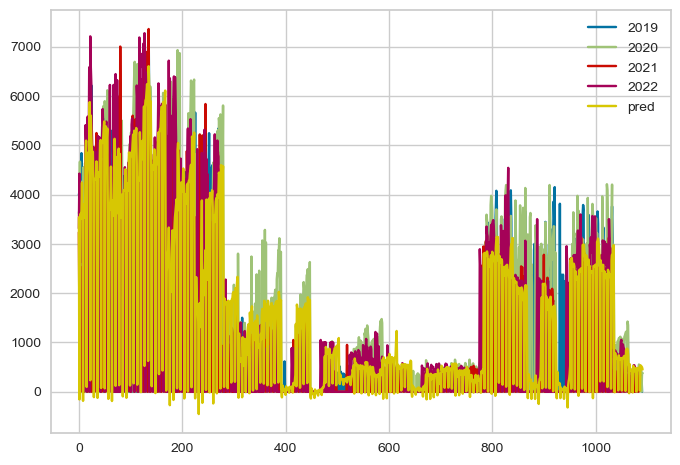

In [300]:
train[(train['year'] == 2019) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
train[(train['year'] == 2020) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
train[(train['year'] == 2021) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
train[(train['year'] == 2022) & (train['day'] > 3) &
      (train['month'] == 3)]['price(원/kg)'].reset_index(drop=True).plot()
pd.read_csv('./rg-scale.csv')['answer'].plot()

plt.legend(['2019','2020','2021','2022','pred'])

In [301]:
train_location1 = pd.DataFrame(pd.DataFrame(train.groupby('location'))[1][0]).reset_index(drop=True)
train_location2 = pd.DataFrame(pd.DataFrame(train.groupby('location'))[1][1]).reset_index(drop=True)

test_location1 = pd.DataFrame(pd.DataFrame(test.groupby('location'))[1][0]).reset_index(drop=True)
test_location2 = pd.DataFrame(pd.DataFrame(test.groupby('location'))[1][1]).reset_index(drop=True)

train_location1 = train_location1[(train_location1['month'] == 2) |
                                 (train_location1['month'] == 3) |
                                 (train_location1['month'] == 4)]

In [302]:
from pycaret import regression
regression.setup(data=train,target='price(원/kg)'
                     ,train_size=0.8
                     ,fold=10
                     ,session_id=42)

,Description,Value
0,Session id,42
1,Target,price(원/kg)
2,Target type,Regression
3,Original data shape,"(58243, 9)"
4,Transformed data shape,"(58243, 9)"
5,Transformed train set shape,"(46594, 9)"
6,Transformed test set shape,"(11649, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [303]:
best = regression.compare_models(n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,269.0113,539685.0114,733.6879,0.8207,2.0742,0.1919,0.9510
xgboost,Extreme Gradient Boosting,376.3062,572831.1812,756.4073,0.8094,3.7273,0.2497,0.6410
et,Extra Trees Regressor,256.7785,575343.9468,757.2654,0.8089,1.8888,0.1867,0.7500
catboost,CatBoost Regressor,392.0139,593243.1466,769.8268,0.8026,3.7907,0.2595,2.0640
lightgbm,Light Gradient Boosting Machine,373.3811,594405.9110,770.5582,0.8023,3.5282,0.2688,0.0910
dt,Decision Tree Regressor,300.8682,883174.4586,939.0868,0.7062,2.0179,0.2368,0.0300
gbr,Gradient Boosting Regressor,548.3791,893783.8107,945.1572,0.7026,4.2076,0.3439,0.5280
knn,K Neighbors Regressor,549.1801,940555.5875,969.4518,0.6872,3.4640,0.3954,0.0660
ada,AdaBoost Regressor,776.2861,1314263.1684,1146.2698,0.5627,4.7148,0.3837,0.1080
br,Bayesian Ridge,1152.6277,2478712.9150,1574.1746,0.1755,5.1591,0.8639,0.0180


In [304]:
def prediction(val):
    pred =  0.6*best[0].predict(val) + 0.2*best[1].predict(val) + 0.2*best[2].predict(val)
    return pred

pred1 = prediction(val1)
pred2 = prediction(val2)
pred3 = prediction(val3)
pred4 = prediction(val4)

def cross_metric(act,pred):
    rmse = np.sqrt(mean_squared_error(act,pred))
    print(f"RMSE : {rmse}")
    print('')

cross_metric(actual1,pred1) # 2019 3
cross_metric(actual2,pred2) # 2020 3
cross_metric(actual3,pred3) # 2021 3
cross_metric(actual4,pred4) # 2022 3


RMSE : 403.018061161323

RMSE : 531.6330801373618

RMSE : 427.66015129754015

RMSE : 446.4998757697936



In [292]:
prediction(test.drop('ID',axis=1))


array([3742.63188965,   91.65531921, 3746.01183252, ...,  523.00226428,
        520.3317218 ,  583.61839709])

In [294]:
# for i in test_location1.index:
#     target.loc[i,'answer'] = test_location1.loc[i,'answer']
# target = target.reset_index()

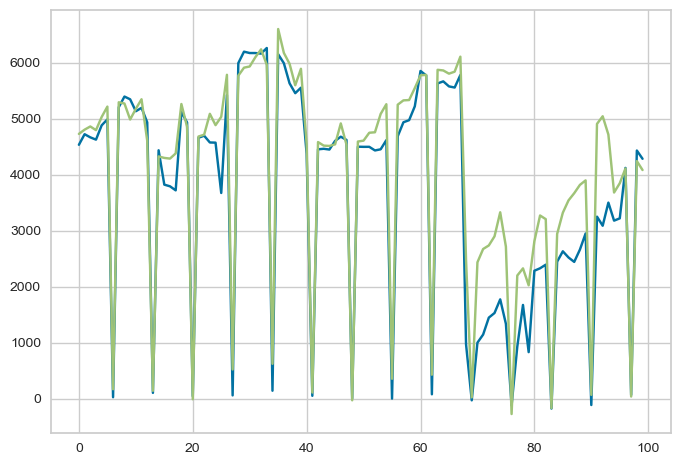

<Axes: >

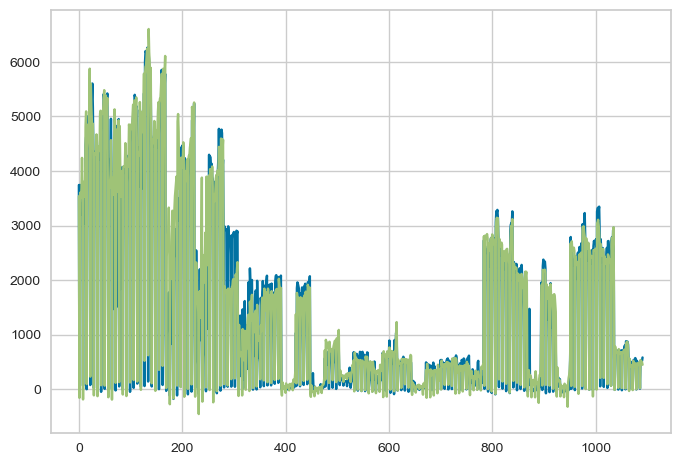

In [295]:
confirm_interval = 1
plt.plot(prediction(test.drop('ID',axis=1))[100*confirm_interval:100*(confirm_interval+1)])
pd.read_csv('./rg-scale.csv')['answer'][100*confirm_interval:100*(confirm_interval+1)].reset_index(drop=True).plot()
plt.show()
plt.plot(prediction(test.drop('ID',axis=1)))
pd.read_csv('./rg-scale.csv')['answer'].reset_index(drop=True).plot()


In [297]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = prediction(test.drop('ID',axis=1)) 
submission.to_csv('./cut_price_7000.csv', index=False)


In [159]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

target = []
for date, name in sorted(korea_holidays.items()):
    target.append(str(date))
train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'
train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    


tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
train = train.drop(tar)
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),Isholiday,Is_Sunday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,0,0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,0,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,0,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,0,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,0,0
...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,0,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,0,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,1,0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,0,0


In [ ]:
train[train['timestamp']]